In [17]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# --- Step 1: Prepare Univariate Data ---
processed_dir = '../data/processed'
full_data_path = os.path.join(processed_dir, 'full_ohlcv_data.csv')
full_data = pd.read_csv(full_data_path, header=[0, 1], index_col=0, parse_dates=True)
tsla_close = full_data['Close']['TSLA'].dropna()

# The daily_returns file has a simple header, so it loads correctly as before
returns_path = os.path.join(processed_dir, 'daily_returns.csv')
daily_returns = pd.read_csv(returns_path, index_col='Date', parse_dates=True)

# --- Step 2: Train the Univariate Model on All Data ---
scaler_uni = MinMaxScaler(feature_range=(0, 1))
scaled_data_uni = scaler_uni.fit_transform(tsla_close.values.reshape(-1, 1))

# Using your updated sequence length
sequence_length = 60
X_train_uni, y_train_uni = [], []
for i in range(sequence_length, len(scaled_data_uni)):
    X_train_uni.append(scaled_data_uni[i-sequence_length:i, 0])
    y_train_uni.append(scaled_data_uni[i, 0])
X_train_uni, y_train_uni = np.array(X_train_uni), np.array(y_train_uni)
X_train_uni = np.reshape(X_train_uni, (X_train_uni.shape[0], X_train_uni.shape[1], 1))

univariate_model = Sequential()
univariate_model.add(LSTM(units=128, return_sequences=True, input_shape=(sequence_length, 1)))
univariate_model.add(Dropout(0.2))
univariate_model.add(LSTM(units=64, return_sequences=True))
univariate_model.add(Dropout(0.2))
univariate_model.add(LSTM(units=32, return_sequences=False))
univariate_model.add(Dropout(0.2))
univariate_model.add(Dense(units=1))
univariate_model.compile(optimizer='adam', loss='mean_squared_error')
print("\nTraining the Univariate LSTM model...")
univariate_model.fit(X_train_uni, y_train_uni, epochs=25, batch_size=32, verbose=0)
print("✅ Univariate LSTM model trained!")





/home/shivers/dev/github.com/AbenezerWork/finance-time-series-forecasting/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training the Univariate LSTM model...
✅ Univariate LSTM model trained!



Generating univariate forecast for the next 180 days...
✅ Univariate forecast complete!


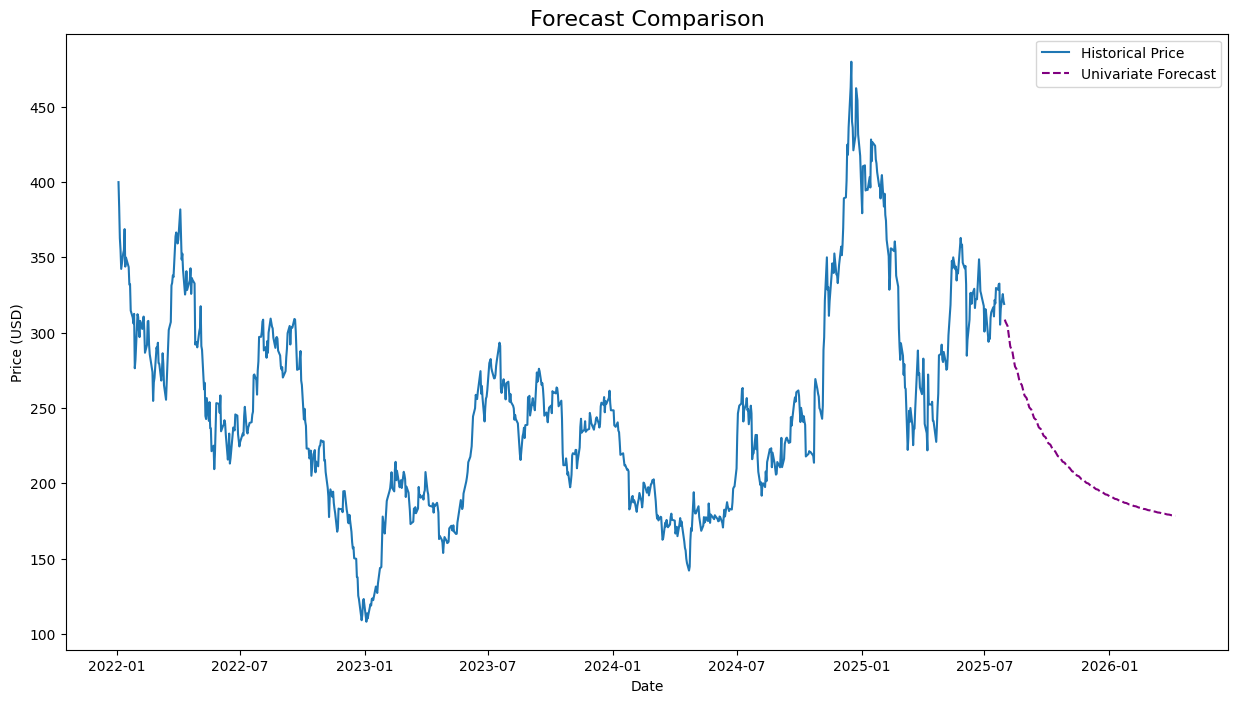

In [13]:

# --- Step 3: Generate the Univariate Forecast ---
# Matching the forecast period to the sequence length
forecast_period = 180
uni_predictions_scaled = []
current_sequence_uni = scaled_data_uni[-sequence_length:].reshape(1, sequence_length, 1)

print(f"\nGenerating univariate forecast for the next {forecast_period} days...")
for i in range(forecast_period):
    next_prediction_scaled = univariate_model.predict(current_sequence_uni, verbose=0)
    uni_predictions_scaled.append(next_prediction_scaled[0, 0])
    new_prediction_reshaped = next_prediction_scaled.reshape(1, 1, 1)
    current_sequence_uni = np.append(current_sequence_uni[:, 1:, :], new_prediction_reshaped, axis=1)

uni_predictions = scaler_uni.inverse_transform(np.array(uni_predictions_scaled).reshape(-1, 1)).flatten()
last_date = tsla_close.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=forecast_period, freq='B')
univariate_forecast_series = pd.Series(uni_predictions, index=future_dates)
print("✅ Univariate forecast complete!")

# --- Step 4: Visualize and Compare (Corrected) ---
plt.figure(figsize=(15, 8))
plt.plot(tsla_close['2022':], label='Historical Price')


#plt.plot(uni_predictions, color='red', linestyle='--', label='Multi-variate Forecast')

plt.plot(univariate_forecast_series, color='purple', linestyle='--', label='Univariate Forecast')
plt.title('Forecast Comparison', fontsize=16)
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.show()

In [14]:
from pypfopt import expected_returns
from pypfopt import risk_models

# --- 1. Prepare Historical Price Data ---
# We only need the historical closing prices for all three assets
prices = full_data['Close'][['TSLA', 'BND', 'SPY']].dropna()

# --- 2. Calculate Expected Annual Returns (mu) ---

# For BND and SPY, we use the historical average
# PyPortfolioOpt has a convenient function for this
mu_hist = expected_returns.mean_historical_return(prices[['BND', 'SPY']])

# For TSLA, we calculate the expected return from our forecast
# Note: univariate_forecast_series is the forecast from our last step
last_actual_price = prices['TSLA'].iloc[-1]
predicted_end_price = univariate_forecast_series.iloc[-1]
# The total return is the percentage change from the last price to the forecasted price
expected_return_tsla = (predicted_end_price / last_actual_price) - 1

# Combine into a single Series for the optimizer
mu = pd.Series({
    'TSLA': expected_return_tsla,
    'BND': mu_hist['BND'],
    'SPY': mu_hist['SPY']
})

print("--- Expected Annual Returns ---")
print(mu)


# --- 3. Calculate the Covariance Matrix (S) ---
# This matrix quantifies the risk and co-movement of the assets
# We calculate it from the full historical price series
S = risk_models.sample_cov(prices)

print("\n--- Covariance Matrix ---")
print(S)

--- Expected Annual Returns ---
TSLA   -0.440884
BND     0.018252
SPY     0.136706
dtype: float64

--- Covariance Matrix ---
Ticker      TSLA       BND       SPY
Ticker                              
TSLA    0.350331  0.001861  0.052950
BND     0.001861  0.003016  0.001150
SPY     0.052950  0.001150  0.033272


--- Maximum Sharpe Ratio Portfolio ---
Expected annual return: 7.3%
Annual volatility: 9.3%
Sharpe Ratio: 0.79
OrderedDict({'TSLA': 0.0, 'BND': 0.53489, 'SPY': 0.46511})

----------------------------------------

--- Minimum Volatility Portfolio ---
Expected annual return: 2.5%
Annual volatility: 5.4%
Sharpe Ratio: 0.46
OrderedDict({'TSLA': 0.0, 'BND': 0.94511, 'SPY': 0.05489})


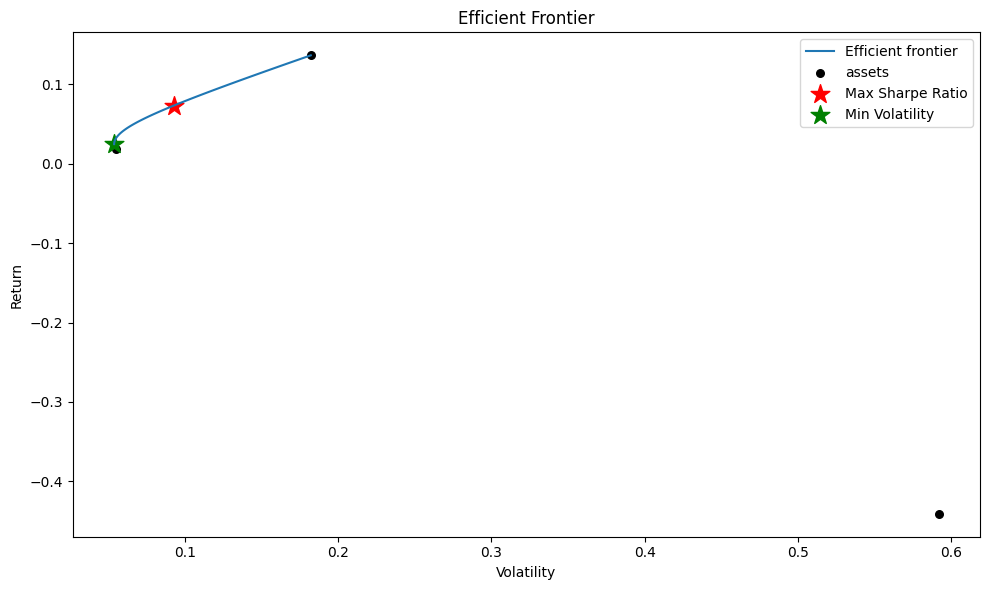

In [15]:
from pypfopt import EfficientFrontier
from pypfopt import plotting

# --- 1. Calculate Key Portfolios ---

# a) Maximum Sharpe Ratio Portfolio (best risk-adjusted return)
ef_max_sharpe = EfficientFrontier(mu, S)
weights_msr = ef_max_sharpe.max_sharpe()
cleaned_weights_msr = ef_max_sharpe.clean_weights()
print("--- Maximum Sharpe Ratio Portfolio ---")
ef_max_sharpe.portfolio_performance(verbose=True)
print(cleaned_weights_msr)

print("\n" + "-"*40 + "\n")

# b) Minimum Volatility Portfolio (safest portfolio)
ef_min_vol = EfficientFrontier(mu, S)
weights_mv = ef_min_vol.min_volatility()
cleaned_weights_mv = ef_min_vol.clean_weights()
print("--- Minimum Volatility Portfolio ---")
ef_min_vol.portfolio_performance(verbose=True)
print(cleaned_weights_mv)


# --- 2. Plot the Efficient Frontier ---

# We need a clean instance of EfficientFrontier to plot the curve
ef_plot = EfficientFrontier(mu, S)

fig, ax = plt.subplots(figsize=(10, 6))
plotting.plot_efficient_frontier(ef_plot, ax=ax, show_assets=True)

# Get the performance of the two key portfolios to plot them as stars
ret_msr, vol_msr, _ = ef_max_sharpe.portfolio_performance()
ret_mv, vol_mv, _ = ef_min_vol.portfolio_performance()

# Add markers for the two key portfolios
ax.scatter(vol_msr, ret_msr, marker="*", s=200, c="r", label="Max Sharpe Ratio")
ax.scatter(vol_mv, ret_mv, marker="*", s=200, c="g", label="Min Volatility")

ax.set_title("Efficient Frontier")
ax.legend()
plt.tight_layout()
plt.show()

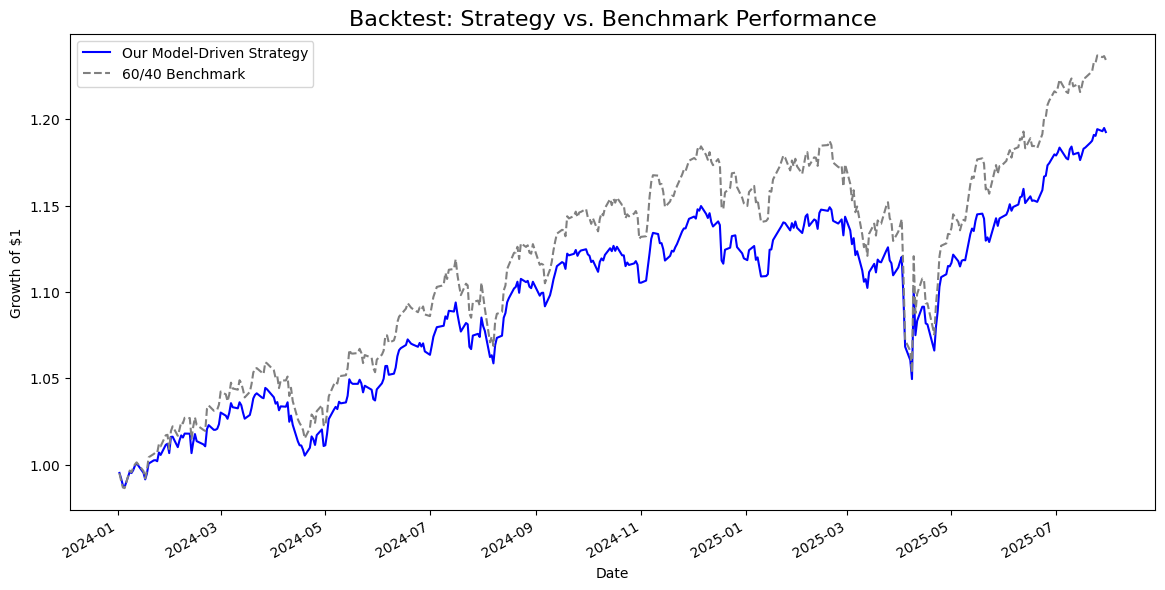

In [19]:
# --- 2. Set up the Backtest Data ---
# Define the backtest start date directly
backtest_start_date = '2024-01-01'
backtest_returns = daily_returns[daily_returns.index >= backtest_start_date]

# --- 3. Define Portfolio Weights ---
# Our model-driven strategy from the Efficient Frontier
strategy_weights = {'TSLA': 0.0, 'BND': 0.53489, 'SPY': 0.46511}

# A simple, common benchmark portfolio
benchmark_weights = {'TSLA': 0.0, 'BND': 0.40, 'SPY': 0.60}

# --- 4. Calculate Daily Portfolio Returns ---
# Multiply the daily asset returns by their weights in each portfolio
strategy_returns = (backtest_returns * pd.Series(strategy_weights)).sum(axis=1)
benchmark_returns = (backtest_returns * pd.Series(benchmark_weights)).sum(axis=1)

# --- 5. Calculate Cumulative Growth ---
# Use cumprod() to calculate the growth of an initial $1 investment
strategy_growth = (1 + strategy_returns).cumprod()
benchmark_growth = (1 + benchmark_returns).cumprod()

# --- 6. Visualize the Results ---
plt.figure(figsize=(14, 7))
strategy_growth.plot(label='Our Model-Driven Strategy', color='blue')
benchmark_growth.plot(label='60/40 Benchmark', color='gray', linestyle='--')
plt.title('Backtest: Strategy vs. Benchmark Performance', fontsize=16)
plt.ylabel('Growth of $1')
plt.xlabel('Date')
plt.legend()
plt.show()